### DG rectangular mesh testing w. $L^2$-projection

##### 1) DG rectangular mesh function (uniform quads)
Let the physical domain be
$$
    \Omega = [x_{\min}, x_{\max}] \times [y_{\min}, y_{\max}]
$$

We split $\Omega$ into $K_x \times K_y$ uniform rectangles by introducing the grid edges
$$
    x_{\text{edges}} = \{ x_0,\ldots, x_{K_x} \}, \quad y_{\text{edges}} = \{ y_0,\ldots, y_{K_y} \}
$$
with $x_0=x_{\min}$, $x_{K_x}=x_{\max}$ and analogously in the $y$-direction.

Each element 
$$
K_e = [x_e, x_{e+1}]\times [y_e, y_{e+1}]
$$ 
is an affine image of the reference square $\hat K = [-1,1]^2$:
$$
    x = x_e + \frac{x_{e+1}-x_e}{2}(r+1), \quad y = y_e + \frac{y_{e+1}-y_e}{2}(s+1)
$$
where $(r,s) \in [-1,1]^2$ and $(x_e,y_e)$ denotes the lower-left corner of element $e$.

For a uniform mesh we have:
$$
    h_x = x_{e+1}-x_e = \frac{x_{\max}-x_{\min}}{K_x}, \quad h_y = y_{e+1}-y_e = \frac{y_{\max}-y_{\min}}{K_y}
$$

The Jacobian determinant of the affine mapping is constant:
\begin{align*}
|J|
&= \Big| \det
\begin{bmatrix}
\frac{\partial x}{\partial r} & \frac{\partial x}{\partial s} \\
\frac{\partial y}{\partial r} & \frac{\partial y}{\partial s}
\end{bmatrix} \Big|
= \Big| \det
\begin{bmatrix}
\frac{x_{e+1}-x_e}{2} & 0 \\
0 & \frac{y_{e+1}-y_e}{2}
\end{bmatrix} \Big|
= \frac{h_x h_y}{4}.
\end{align*}

##### $L^2$ projection math (elementwise)

We have a DG space on each element
$$
    V_h(K_e) = \mathbb{Q}^p=\text{span}\{ \phi_{ij}(r,s) \}_{i,j=0}^p
$$
with orthonormal basis on $[-1,1]$:
$$
    \ell_n = \sqrt{\frac{2n+1}{2}} P_n(r)
$$
where $P_n$ is the Legendre polynomial of degree $n$. On the reference element $\hat K$ we define
$$
    \phi_{ij}(r,s) = \ell_i(r)\ell_j(s)
$$
which satisfy
$$
    \int_{\hat K}\phi_{ij}(r,s)\phi_{mn}(r,s)\,dr\,ds = \delta_{im}\delta_{jn}
$$

The elementwise $L^2$ projection solves:
$$
    \int_{K_e} u_h\,v\,dx\,dy = \int_{K_e} f\,v\,dx\,dy, \quad \forall v\in V_h(K_e)
$$
Now, taking $v=\phi_{mn}$ and using orthonormality with the affine map yields:
$$
    c_{mn}^{(e)} = \int_{\hat K} f\big( x(r), y(s) \big)\,\phi_{mn}(r,s)\,dr\,ds
$$

Thus, the DG coefficients are given by inner products on the reference element, which are evaluated numerically using suitable quadrature rules.

##### **Problem**: What is $f(x,y)$ when we have a grid of pixels?

If we have samples on a grid $\{(x_i,y_i)\}$ with values $f_{i,j}$. A standard choice is to treat $f(x,y)$ as the bilinear interpolant of the pixel grid and evaluate that interpolant at quadrature points. 

In [13]:
import numpy as np

# Function to create the DG mesh 
def make_structured_quad_mesh(domain, Kx, Ky, p):
    """
    Structured quad mesh on a rectangular domain.

    domain = (xmin, xmax, ymin, ymax)
    """
    xmin, xmax, ymin, ymax = domain

    x_edges = np.linspace(xmin, xmax, Kx + 1)
    y_edges = np.linspace(ymin, ymax, Ky + 1)

    mesh = {
        "domain": domain,
        "Kx": Kx,
        "Ky": Ky,
        "x_edges": x_edges,
        "y_edges": y_edges,
        "hx": np.diff(x_edges),
        "hy": np.diff(y_edges),
        "p": p
    }
    return mesh




In [14]:

# Helper function: orthonormal Legendre basis values on [-1,1]
# l_n(r) = sqrt((2n + 1) / 2) * P_n(r)
from scipy.special import eval_legendre
def eval_orthonormal_legendre_1d(x, p):
    """
    Evaluate orthonormal Legendre basis l_0,...,l_p at points x.
    
    Returns array of shape (p+1, len(x)).
    """
    x = np.asarray(x)
    out = np.zeros((p + 1, x.size))

    for n in range(p + 1):
        out[n, :] = np.sqrt((2*n + 1)/2.0) * eval_legendre(n, x)

    return out


from scipy.interpolate import RegularGridInterpolator
# Helper function: Create a function f(x,y) from the pixel grid, defined by the bilinear interpolator (callable)
def make_bilinear_function(img, xgrid, ygrid, fill_value=0.0):
    """
    Returns a callable f(x,y) performing bilinear interpolation
    of img on the tensor grid (xgrid,ygrid).
    """ 
    interp = RegularGridInterpolator(
        (ygrid, xgrid), img, method="linear",
        bounds_error=False, fill_value=fill_value
    )
    
    def f(x,y):
        x = np.asarray(x)
        y = np.asarray(y)
        pts = np.column_stack([y.ravel(), x.ravel()])
        vals = interp(pts)
        shape = np.broadcast(x, y).shape
        return vals.reshape(shape)

    
    return f    


### Elementwise $L^2$ projection onto a DG modal basis

Let $f(x,y)$ be the bilinear interpolant of the discrete image data
$\{f_{ij}\}$ defined on a Cartesian grid $(x_i,y_j)$.

The physical domain $\Omega$ is decomposed into uniform rectangular elements
$$
K_{e} = [x_e,x_{e+1}]\times[y_e,y_{e+1}],
$$
where $\{x_e\}_{e=0}^{K_x}$ and $\{y_e\}_{e=0}^{K_y}$ denote the grid edges.

Each element is mapped affinely from the reference square $\hat K=[-1,1]^2$ via
$$
x(r) = x_e + \tfrac{h_x}{2}(r+1), \qquad
y(s) = y_e + \tfrac{h_y}{2}(s+1).
$$

On $\hat K$, we use the tensor-product orthonormal Legendre basis
$$
\phi_{ij}(r,s) = \ell_i(r)\,\ell_j(s), \qquad
\ell_n(t) = \sqrt{\tfrac{2n+1}{2}}\,P_n(t),
$$
where $P_n$ is the Legendre polynomial of degree $n$.

The DG approximation on each element is
$$
u_h|_{K_e}(x,y) = \sum_{i=0}^p \sum_{j=0}^p c_{ij}^{(e)} \,\phi_{ij}(r,s).
$$

The elementwise $L^2$ projection satisfies
$$
c_{ij}^{(e)} = \int_{\hat K} f(x(r),y(s))\,\phi_{ij}(r,s)\,dr\,ds.
$$

Using tensor-product Gauss–Legendre quadrature with nodes
$\{r_a,w_a\}_{a=1}^{n_q}$ and $\{s_b,v_b\}_{b=1}^{n_q}$, this integral is
approximated by
$$
c_{ij}^{(e)} \approx
\sum_{b=1}^{n_q}\sum_{a=1}^{n_q}
v_b\,w_a\,
f\!\left(x(r_a),y(s_b)\right)\,
\ell_i(r_a)\,\ell_j(s_b).
$$

The fast implementation evaluates the same expression by first summing in the
$r$-direction and then in the $s$-direction.


In [15]:

from numpy.polynomial.legendre import leggauss
# Function to compute L2 projection onto DG modal coefficients
def l2_project_pixels_to_dg(img, xgrid, ygrid, mesh, quad_order=None):
    """
    Elementwise L2 projection of an image onto DG(Q^p) on a uniform quad mesh.

    Uses orthonormal tensor-product Legendre basis on reference [-1,1]^2:
        phi_ij(r,s) = l_i(r) l_j(s)

    Coefficients per element:
        c_ij ~ sum_b sum_a (v_b w_a) f(x(r_a),y(s_b)) l_i(r_a) l_j(s_b)
    """
    
    img = np.asarray(img)
    Kx, Ky, p = mesh["Kx"], mesh["Ky"], mesh["p"]
    x_edges, y_edges = mesh["x_edges"], mesh["y_edges"]

    
    if quad_order is None:
        # Exact quadrature up to polynomial degree 2p requires atleast p+1 points in 1D
        # Here, f is not a polynomial, so we choose slightly higher
        quad_order = max(p + 2, 6)
    
    # Create the function f(x,y) (as a bilinear function)
    f = make_bilinear_function(img, xgrid=xgrid, ygrid=ygrid)
    
    # 1D Gauss-Legendre nodes/weights on [-1,1]
    rq, wq = leggauss(quad_order)   # r-nodes and weights
    sq, vq = leggauss(quad_order)   # s-nodes and weights
    
    # basis values on quad nodes
    Lr = eval_orthonormal_legendre_1d(rq, p)    # shape (p+1, nq)
    Ls = eval_orthonormal_legendre_1d(sq, p)    # shape (p+1, nq)
    
    # Storage: coeffs[ey, ex, i, j] for element (ey,ex) and mode (i,j)
    coeffs = np.zeros((Ky, Kx, p + 1, p + 1), dtype=float)
    
    # Precompute reference tensor grid once:
    # R[b,a] = r_a, S[b,a] = s_b, and weight W[b,a] = v_b*w_a
    # (This is independent of the element and reused for all elements.)
    R, S = np.meshgrid(rq, sq, indexing="xy")       # both (nq, nq)
    W = np.outer(vq, wq)                            # (nq, nq) with rows b (s) and cols a (r)
    
    for ey in range(Ky):
        y0, y1 = y_edges[ey], y_edges[ey + 1]
        # physical y at quadrature nodes for all (r,s) in this row of elements
        Y = y0 + 0.5 * (y1 - y0) * (S + 1.0)        # (nq, nq)
        
        for ex in range(Kx):
            x0, x1 = x_edges[ex], x_edges[ex + 1]
            X = x0 + 0.5 * (x1 - x0) * (R + 1.0)    # (nq, nq)
            
            # Sample f at all quadrature points on this element
            F = f(X, Y)                     # (nq, nq)
            
            # Compute coefficients
            for i in range(p + 1):
                for j in range(p + 1):
                    ssum = 0.0
                    for b in range(quad_order):     # s-index (row)
                        lj_sb = Ls[j, b]
                        for a in range(quad_order): # r-index (col)
                            li_sa = Lr[i, a]
                            ssum += W[b, a] * F[b, a] * li_sa * lj_sb
                    coeffs[ey, ex, i, j] = ssum
    
    return {"mesh": mesh,
            "coeffs": coeffs, 
            "basis": "orthonormal_legendre_tensor", 
            "quad_order": quad_order}


In [16]:

def l2_project_pixels_to_dg_fast(img, xgrid, ygrid, mesh, quad_order=None):

    img = np.asarray(img)
    Kx, Ky, p = mesh["Kx"], mesh["Ky"], mesh["p"]
    x_edges, y_edges = mesh["x_edges"], mesh["y_edges"]

    if quad_order is None:
        quad_order = max(p + 2, 6)

    f = make_bilinear_function(img, xgrid=xgrid, ygrid=ygrid)

    rq, wq = leggauss(quad_order)
    sq, vq = leggauss(quad_order)

    Lr = eval_orthonormal_legendre_1d(rq, p)  # (p+1, nq)
    Ls = eval_orthonormal_legendre_1d(sq, p)  # (p+1, nq)

    coeffs = np.zeros((Ky, Kx, p + 1, p + 1), dtype=float)

    R, S = np.meshgrid(rq, sq, indexing="xy")  # (nq,nq)
    W = np.outer(vq, wq)                       # (nq,nq)

    for ey in range(Ky):
        y0, y1 = y_edges[ey], y_edges[ey + 1]
        Y = y0 + 0.5 * (y1 - y0) * (S + 1.0)

        for ex in range(Kx):
            x0, x1 = x_edges[ex], x_edges[ex + 1]
            X = x0 + 0.5 * (x1 - x0) * (R + 1.0)

            F = f(X, Y)        # (nq, nq)
            G = W * F          # weights included

            # Integrate in r:  A[b,i] = sum_a G[b,a] * Lr[i,a]
            # (nq,nq) @ (nq,p+1) -> (nq,p+1)
            A = G @ Lr.T

            # Integrate in s:  c[j,i] = sum_b Ls[j,b] * A[b,i]
            # (p+1,nq) @ (nq,p+1) -> (p+1,p+1)
            c_ji = Ls @ A

            coeffs[ey, ex, :, :] = c_ji.T  # store as (i,j)

    return {"mesh": mesh, "coeffs": coeffs, "basis": "orthonormal_legendre_tensor", "quad_order": quad_order}
             
    

### Reconstruction of a DG modal field on a Cartesian grid

Given modal coefficients $c^{(e)}_{mn}$ on each element $K_e$, define
$$
u_h|_{K_e}(x,y) = \sum_{m=0}^p\sum_{n=0}^p c^{(e)}_{mn}\,\ell_m(r)\,\ell_n(s),
$$
where $(r,s)\in[-1,1]^2$ are reference coordinates obtained from
$$
r = 2\frac{x-x_e}{h_x}-1,\qquad s = 2\frac{y-y_e}{h_y}-1.
$$
To evaluate on a Cartesian grid $\{(x_i,y_j)\}\subset\Omega$, assign each
$(x_i,y_j)$ to the unique element by the rule:
left/bottom edges included, right/top excluded (except global boundary),
then compute $u_h(x_i,y_j)$ by the formula above.


In [17]:
def eval_dg_modal_pointwise(dg, X, Y, fill_value=0.0):
    """
    Pointwise evaluation of DG modal field:
      1) find element (ex, ey) using x_edges/y_edges (half-open convention)
      2) map (x,y) -> (r,s) in [-1,1]^2
      3) u = sum_{i,j} c_ij * l_i(r) * l_j(s)
    """
    mesh = dg["mesh"]
    coeffs = dg["coeffs"]  # (Ky, Kx, p+1, p+1)

    xmin, xmax, ymin, ymax = mesh["domain"]
    Kx, Ky, p = mesh["Kx"], mesh["Ky"], mesh["p"]
    x_edges, y_edges = mesh["x_edges"], mesh["y_edges"]

    X = np.asarray(X)
    Y = np.asarray(Y)
    Xb, Yb = np.broadcast_arrays(X, Y)
    Xf = Xb.ravel()
    Yf = Yb.ravel()

    U = np.full_like(Xf, fill_value, dtype=float)

    for k in range(Xf.size):
        x = Xf[k]
        y = Yf[k]

        # outside domain check (include boundary)
        if (x < xmin) or (x > xmax) or (y < ymin) or (y > ymax):
            continue

        # element indices via edges:
        # left/bottom included, right/top excluded, except global boundary handled by clamp
        ex = np.searchsorted(x_edges, x, side="right") - 1
        ey = np.searchsorted(y_edges, y, side="right") - 1
        ex = int(np.clip(ex, 0, Kx - 1))
        ey = int(np.clip(ey, 0, Ky - 1))

        # element bounds
        x0, x1 = x_edges[ex], x_edges[ex + 1]
        y0, y1 = y_edges[ey], y_edges[ey + 1]

        # map to reference coordinates
        r = 2.0 * (x - x0) / (x1 - x0) - 1.0
        s = 2.0 * (y - y0) / (y1 - y0) - 1.0

        # basis values at this point
        lr = eval_orthonormal_legendre_1d(np.array([r]), p)[:, 0]
        ls = eval_orthonormal_legendre_1d(np.array([s]), p)[:, 0]

        # modal sum
        Ce = coeffs[ey, ex, :, :]  # (p+1, p+1)
        U[k] = np.sum(Ce * lr[:, None] * ls[None, :])

    return U.reshape(Xb.shape)


### Testing on Shepp-Logan Phantom

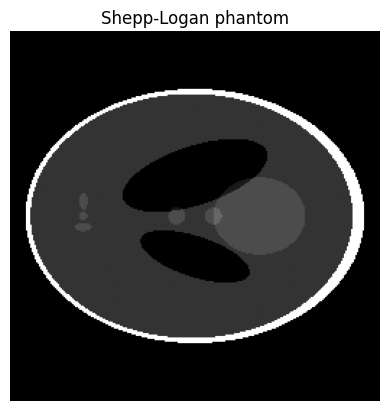

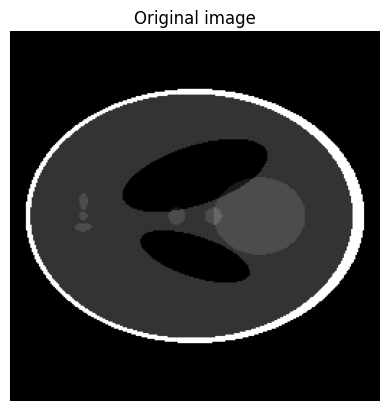

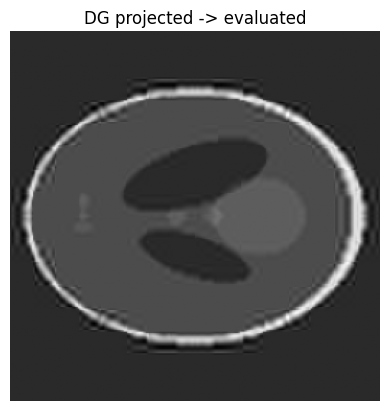

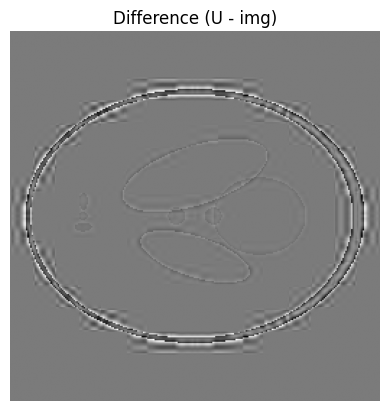

In [ ]:
import odl
import matplotlib.pyplot as plt

xmin, xmax, ymin, ymax = -1, 1, -1, 1
domain = [xmin, xmax, ymin, ymax]


space = odl.uniform_discr(
    min_pt=[xmin, ymin],
    max_pt=[xmax, ymax],
    shape=[256, 256],
    dtype='float32'
)

phantom = odl.phantom.shepp_logan(space, modified=True)
plt.imshow(phantom, cmap='gray')
plt.title("Shepp-Logan phantom")
plt.axis("off")

img = phantom.asarray()
Ny, Nx = img.shape

poly_deg = 3

Kx, Ky = 16, 16

dg_mesh = make_structured_quad_mesh(domain, Kx=Kx, Ky=Ky, p=poly_deg)

grid = space.grid
xgrid, ygrid = grid.coord_vectors

# Returns dictionary with: "mesh", "coeffs", "basis", "quad_order"
dg_dict = l2_project_pixels_to_dg_fast(img=img, xgrid=xgrid, ygrid=ygrid, 
                                       mesh=dg_mesh)

X, Y = np.meshgrid(xgrid, ygrid, indexing="xy")  # X,Y shape (Ny,Nx)
U = eval_dg_modal_pointwise(dg=dg_dict, X=X, Y=Y)


# Plot both to see if anything is wrong

import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img, cmap="gray")
plt.title("Original image")
plt.axis("off")

plt.figure()
plt.imshow(U, cmap="gray")
plt.title("DG projected -> evaluated")
plt.axis("off")

plt.figure()
plt.imshow(U - img, cmap="gray")
plt.title("Difference (U - img)")
plt.axis("off")
plt.show()
